In [2]:
import numpy as np
import cv2
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import math
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import KMeans
from scipy.optimize import minimize
from pathlib import Path
from plyfile import PlyData
from collections import Counter


In [3]:
def calculate_normal_vector(points):
    pca = PCA(n_components=3)
    pca.fit(points)
    normal_vector = pca.components_[-1]  # The normal vector is the eigenvector with the smallest eigenvalue

    normal_vector = np.array(normal_vector)
    angle_with_x_axis = np.arccos(np.dot(normal_vector, [1, 0, 0]))
    angle_with_y_axis = np.arccos(np.dot(normal_vector, [0, 1, 0]))
    angle_with_z_axis = np.arccos(np.dot(normal_vector, [0, 0, 1]))
    normal_vector = [angle_with_x_axis, angle_with_y_axis, angle_with_z_axis]
    # print(normal_vector)
    return normal_vector

def angle_with_z_axis(vector):
    vector = vector / np.linalg.norm(vector)
    return np.arccos(np.dot(vector, [0, 0, -1]))

In [4]:
def xy2radius(x, y):
    return math.sqrt(x**2 + y**2)

def xy2theta(x, y):
    return math.atan2(y, x)

In [5]:
def apply_gabor_filter(image, ksize=13, sigma=1, theta=0, lambd=7, gamma=0.5):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
    return cv2.filter2D(image, cv2.CV_32F, kernel)

def cluster_images(images, n_clusters):
    flattened_images = [img.flatten() for img in images]
    kmeans = KMeans(n_clusters=n_clusters).fit(flattened_images)
    return kmeans.labels_, kmeans.cluster_centers_

In [46]:
class Zone:
    def __init__(self):
        self.points = []

class CZM:
    def __init__(self, ply_file_path):
        self.ply_file_path = ply_file_path
        self.ply_file_name = os.path.splitext(os.path.basename(ply_file_path))[0]  # 'frame002846-1581624937_362' 같은 형태로 파일 이름을 저장

        self.point_cloud = None

        # Define range parameters
        self.min_range_ = 4
        self.min_range_z2_ = 12
        self.min_range_z3_ = 28
        self.min_range_z4_ = 60
        self.max_range_ = 100.0
        self.min_ranges_ = [self.min_range_, self.min_range_z2_, self.min_range_z3_, self.min_range_z4_]

        # Define zone, sector, and ring parameters
        self.num_zones = 4
        self.num_sectors_each_zone = [72, 48, 48, 64]
        self.num_rings_each_zone = [4, 4, 5, 5]
        self.ring_sizes_ = [
            (self.min_range_z2_ - self.min_range_) / self.num_rings_each_zone[0],
            (self.min_range_z3_ - self.min_range_z2_) / self.num_rings_each_zone[1],
            (self.min_range_z4_ - self.min_range_z3_) / self.num_rings_each_zone[2],
            (self.max_range_ - self.min_range_z4_) / self.num_rings_each_zone[3]
        ]
        self.sector_sizes_ = [
            2 * math.pi / self.num_sectors_each_zone[0],
            2 * math.pi / self.num_sectors_each_zone[1],
            2 * math.pi / self.num_sectors_each_zone[2],
            2 * math.pi / self.num_sectors_each_zone[3]
        ]
        
        self.images_to_cluster = []
        self.labels = []
        self.max_stripes_list = []

        self.cluster_labels = {
            0: [3, 23],
            1: [6, 31, 33, 19, 34],
            2: [4, 17, 8, 18, 27]
        }

        self.label_list = []

        # Load point cloud
        self.load_point_cloud()
        
    def read_ply(self, filename):
        """ read XYZ and label from filename PLY file """
        plydata = PlyData.read(filename)
        pc = plydata['vertex'].data
        pc_array = np.array([[x, y, z, label] for x, y, z, _, _, _, _, _, _, label, _, _, _ in pc])
        return pc_array

    def load_point_cloud(self):
        self.point_cloud = self.read_ply(self.ply_file_path)
        # pcd = o3d.io.read_point_cloud(self.pcd_file_path)
        # all_points = np.asarray(pcd.points)
        # z_values = [pt[2] for pt in all_points]
        # min_z = min(z_values)
        # max_z = max(z_values)
        
        # 원본 포인트 클라우드를 시각화
        # o3d.visualization.draw_geometries([pcd])
        
    def calculate_normal_vector(self, points):
        pca = PCA(n_components=3)
        pca.fit(points)
        normal_vector = pca.components_[-1]

        normal_vector = np.array(normal_vector)
        angle_with_x_axis = np.arccos(np.dot(normal_vector, [1, 0, 0]))
        angle_with_y_axis = np.arccos(np.dot(normal_vector, [0, 1, 0]))
        angle_with_z_axis = np.arccos(np.dot(normal_vector, [0, 0, 1]))
        normal_vector = [angle_with_x_axis, angle_with_y_axis, angle_with_z_axis]
        # print(normal_vector)
        return normal_vector

    def angle_with_z_axis(self, vector):
        vector = vector / np.linalg.norm(vector)
        return np.arccos(np.dot(vector, [0, 0, -1]))

    # def apply_gabor_filter(self, image, ksize=7, sigma=1, theta=0, lambd=7, gamma=0.5):
    #     kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma)
    #     # return cv2.filter2D(image, cv2.CV_32F, kernel)
    #     return cv2.filter2D(image, -1, kernel)
        
    def apply_gabor_filter(self,image, angle):
        ksize = 15
        sigma = 5
        lambd = 3
        gamma = 0.5
        psi = 0  # phase offset
        theta = angle * np.pi / 8

        gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi)
        
        filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)

        # 임계값 설정 및 스트라이프 영역 검출
        threshold = np.max(filtered_image) * 0.9
        stripe_regions = filtered_image > threshold
        stripe_image = np.uint8(stripe_regions * 255)

        return stripe_image
        # return filtered_image

    def count_stripes(self,image, min_length=5):
        contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        count = 0
        for contour in contours:
            length = cv2.arcLength(contour, True) # 외곽선의 길이 계산
            if length > min_length: # 길이가 임계값보다 크면 카운트
                count += 1
        return count

    # def extract_features(self, image):
    #     features = []

    #     for angle in range(8):
    #         filtered_image = self.apply_gabor_filter(image, angle)
    #         features.append(np.mean(filtered_image))
    #         features.append(np.std(filtered_image))
    #     return features

    def extract_features(self, image, image_sector_index):
        max_stripes = 0
        best_image = None

        for angle in range(8):
            filtered_image = self.apply_gabor_filter(image, angle)
            num_stripes = self.count_stripes(filtered_image)
            if num_stripes > max_stripes:
                max_stripes = num_stripes
                best_image = filtered_image

        if best_image is not None:
            # print(max_stripes)
            
            self.images_to_cluster.append(best_image.flatten())
            self.labels.append(image_sector_index)
            self.max_stripes_list.append(max_stripes)
        else :
            best_image = np.zeros((15, 15), dtype=np.uint8)
            self.images_to_cluster.append(best_image.flatten())
            self.labels.append(image_sector_index)
            self.max_stripes_list.append(max_stripes)

    def remove_specific_pattern(self, image, threshold):
        # 패딩 추가 (상, 하, 좌, 우 1픽셀씩)
        padded_image = np.pad(image, pad_width=1, mode='constant', constant_values=0)

        # 원래 이미지와 패딩된 이미지의 차이 계산 (상하좌우)
        diff_up = padded_image[:-2, 1:-1] - padded_image[1:-1, 1:-1]
        diff_down = padded_image[2:, 1:-1] - padded_image[1:-1, 1:-1]
        diff_left = padded_image[1:-1, :-2] - padded_image[1:-1, 1:-1]
        diff_right = padded_image[1:-1, 2:] - padded_image[1:-1, 1:-1]

        # 조건에 맞는 픽셀 찾기 (상하좌우 차이가 모두 threshold보다 큰 경우)
        condition = (diff_up > threshold) & (diff_down > threshold) & (diff_left > threshold) & (diff_right > threshold)

        # 조건에 맞는 픽셀을 0으로 설정
        result_image = np.copy(image)
        result_image[condition] = 0

        return result_image

    # def count_stripes(self, image, theta):
    #     filtered_image = self.apply_gabor_filter(image, ksize=13, sigma=1, theta=theta, lambd=7, gamma=0.5)
    #     local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #     return np.sum(local_maxima)
    # def count_stripes(self, image, theta):
    #     filtered_image = self.apply_gabor_filter(image, ksize=15, sigma=15, theta=theta, lambd=2, gamma=1)
    #     local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #     total_stripes = np.sum(local_maxima)
    #     if total_stripes == 0:
    #         return 0, None  # 또는 적절한 이미지로 대체 가능합니다.
    #     return total_stripes, filtered_image


    # def count_stripes(self, image, theta):
    #     ksizes = [3, 5, 7, 9, 11, 13]
    #     lambdas = [0.1,0.5,1,3,5,7,9]
    #     thetas = [np.pi * i / 4 for i in range(8)]
    #     total_stripes_all = []

    #     for ksize in ksizes:
    #         for lambd in lambdas:
    #             for theta in thetas:
    #                 filtered_image = self.apply_gabor_filter(image, ksize=ksize, sigma=15, theta=theta, lambd=lambd, gamma=1)
    #                 local_maxima = (filtered_image == cv2.dilate(filtered_image, np.ones((3,3))))
    #                 total_stripes = np.sum(local_maxima)
    #                 total_stripes_all.append(total_stripes)

    #     if all(stripe == 0 for stripe in total_stripes_all):
    #         return 0, None
    #     return total_stripes_all, filtered_image


    # def analyze_cluster(self, cluster_images):
    #     thetas = [np.pi * i / 4 for i in range(8)]
    #     stripe_counts = [np.mean([self.count_stripes(img, theta=t) for t in thetas]) for img in cluster_images]
    #     return np.mean(stripe_counts)

    def analyze_cluster(self, labels, cluster_label):
        cluster_stripes = [stripe for idx, stripe in enumerate(self.max_stripes_list) if labels[idx] == cluster_label]
        if cluster_stripes:
            mean_stripe_count = np.mean(cluster_stripes)
        else:
            mean_stripe_count = 0
        return mean_stripe_count


    def segment_czm(self):
        ring_sizes_ = [(self.min_range_z2_ - self.min_range_) / self.num_rings_each_zone[0],
                    (self.min_range_z3_ - self.min_range_z2_) / self.num_rings_each_zone[1],
                    (self.min_range_z4_ - self.min_range_z3_) / self.num_rings_each_zone[2],
                    (self.max_range_ - self.min_range_z4_) / self.num_rings_each_zone[3]]

        sector_sizes_ = [2 * math.pi / self.num_sectors_each_zone[0], 
                        2 * math.pi / self.num_sectors_each_zone[1], 
                        2 * math.pi / self.num_sectors_each_zone[2], 
                        2 * math.pi / self.num_sectors_each_zone[3]]

        sector_indices = [] 

        czm = [[
            [Zone() for _ in range(self.num_sectors_each_zone[zone_idx])]
            for _ in range(self.num_rings_each_zone[zone_idx])
        ] for zone_idx in range(self.num_zones)]

        for pt in self.point_cloud:
            x, y, z, label = pt
            r = xy2radius(x, y)
            if r <= self.max_range_ and r > self.min_range_:
                theta = xy2theta(x, y)
                zone_idx = ring_idx = sector_idx = 0

                if r < self.min_range_z2_:
                    zone_idx = 0
                    ring_idx = min(int((r - self.min_range_) / ring_sizes_[0]), self.num_rings_each_zone[0]-1)
                    sector_idx = min(int(theta / sector_sizes_[0]), self.num_sectors_each_zone[0]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z, label])
                elif r < self.min_range_z3_:
                    zone_idx = 1
                    ring_idx = min(int((r - self.min_range_z2_) / ring_sizes_[1]), self.num_rings_each_zone[1]-1)
                    sector_idx = min(int(theta / sector_sizes_[1]), self.num_sectors_each_zone[1]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z, label])
                elif r < self.min_range_z4_:
                    zone_idx = 2
                    ring_idx = min(int((r - self.min_range_z3_) / ring_sizes_[2]), self.num_rings_each_zone[2]-1)
                    sector_idx = min(int(theta / sector_sizes_[2]), self.num_sectors_each_zone[2]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z, label])
                else:
                    zone_idx = 3
                    ring_idx = min(int((r - self.min_range_z4_) / ring_sizes_[3]), self.num_rings_each_zone[3]-1)
                    sector_idx = min(int(theta / sector_sizes_[3]), self.num_sectors_each_zone[3]-1)
                    czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z, label])
                    
                # czm[zone_idx][ring_idx][sector_idx].points.append([x, y, z])
                sector_indices.append((zone_idx, ring_idx, sector_idx)) # 인덱스 추가
        return czm, sector_indices
        #sector_indices 는 각 포인트마다 몇 번째 섹터에 속하는지 나타냄. 

    def process_sectors(self, sectors, img_dim=15, MIN_POINTS=10, MAX_Z_DIFF=0.8): # MAX_Z_DIFF 파라미터 추가
        images = []
        traversable_points = []
        all_image_vectors = []
        image_sector_indices = []
        label_counter = []

        

        for zone_idx, layer in enumerate(sectors):
            for ring_idx, ring in enumerate(layer):
                for sector_idx, sector in enumerate(ring):
                    if len(sector.points) > MIN_POINTS:
                        points = np.array([pt[:3] for pt in sector.points])
                        normal_vector = calculate_normal_vector(points)

                        sector_center_x = np.mean(points[:, 0])
                        sector_center_y = np.mean(points[:, 1])
                        sector_center_z = np.mean(points[:, 2])

                        z_values = [pt[2] for pt in sector.points]
                        min_z, max_z = min(z_values), max(z_values)

                        # z 좌표의 최대값과 최소값의 차이가 일정 이하인 경우만 처리
                        if angle_with_z_axis(normal_vector) >= 1.1 and angle_with_z_axis(normal_vector) <= 1.9 and (max_z - min_z) <= MAX_Z_DIFF:
                            traversable_points.extend(points)
                            image = np.zeros((img_dim, img_dim), dtype=np.uint8)

                            x_values = [pt[0] for pt in sector.points]
                            y_values = [pt[1] for pt in sector.points]

                            min_x, max_x = min(x_values), max(x_values)
                            min_y, max_y = min(y_values), max(y_values)

                            for pt in sector.points:
                                normalized_x = int((pt[0] - min_x) / (max_x - min_x) * (img_dim - 1))
                                normalized_y = int((pt[1] - min_y) / (max_y - min_y) * (img_dim - 1))
                                normalized_z = int((pt[2] - min_z) / (max_z - min_z) * 255)

                                image[normalized_y, normalized_x] = normalized_z

                            image_2d = image.reshape(img_dim, img_dim)

                            labels = [pt[3] for pt in sector.points]
                            most_common_label = Counter(labels).most_common(1)[0][0]
                            label_counter.append(most_common_label)

                            for cluster_name, label_set in self.cluster_labels.items():
                                if most_common_label in label_set:
                                    self.label_list.append(cluster_name)
                                    break

                            image_2d = self.remove_specific_pattern(image_2d,15)

                            images.append(image_2d)
                            image_sector_indices.append((zone_idx, ring_idx, sector_idx)) # 해당 이미지의 sector 인덱스 추가

                            image_vector = image_2d.reshape(-1, 1)
                            all_image_vectors.append(image_vector)
        

        return images, image_sector_indices

    def visualize_clusters(self, images, sector_indices, n_clusters, base_output_folder):
        for img, sector_index in zip(images, sector_indices):
            self.extract_features(img, sector_index)
        print("length of images :", len(images))     
        print("length of mst : " , len(self.max_stripes_list))  
        print(self.max_stripes_list)

        kmeans = KMeans(n_clusters=n_clusters).fit(np.array(self.max_stripes_list).reshape(-1, 1))
        # kmeans = KMeans(n_clusters=n_clusters).fit(X)
        # stripe_counts = [self.analyze_cluster([img])[0] for img in images]

        sector_cluster_mapping = {}

        # Save images to clusters
        for i, label in enumerate(kmeans.labels_):
            max_stripes = self.max_stripes_list[i]
            best_image = self.images_to_cluster[i].reshape(images[i].shape)
            combined_image = np.hstack((images[i], best_image))

            cluster_path = os.path.join(base_output_folder, f"cluster_{label}")
            save_path = os.path.join(cluster_path, f"{label}_stripes_{max_stripes}_{i}.png")  # 파일 이름에 max_stripes 추가
            if not os.path.exists(cluster_path):
                os.makedirs(cluster_path)
            # cv2.imwrite(os.path.join(cluster_path, f"image_{i}.png"), images[i])
            cv2.imwrite(save_path, combined_image)

            # Map sector indices to clusters
            sector_index = sector_indices[i]
            sector_cluster_mapping[sector_index] = label

        values_list = list(sector_cluster_mapping.values())
        similarity_list = [1 if values_list[i] == self.label_list[i] else 0 for i in range(len(values_list))]
        
        print("values list:", values_list) 
        print("label_list:", self.label_list)
        
        average_similarity = sum(similarity_list) / len(similarity_list)

        print("Average Similarity:", average_similarity)    

        # Analyze clusters
        cluster_stripe_counts = {}
        for i in range(n_clusters):
            # cluster_images = [img for idx, img in enumerate(images) if kmeans.labels_[idx] == i]
            cluster_stripe_counts = {i: self.analyze_cluster(kmeans.labels_, i) for i in range(n_clusters)}

        # Sort clusters by mean stripe count
        sorted_clusters = sorted(cluster_stripe_counts.items(), key=lambda x: x[1], reverse=True)
        print(sorted_clusters)

        # Visualize clusters
        for cluster_index, _ in sorted_clusters:
            cluster_path = os.path.join(base_output_folder, f"cluster_{cluster_index}")
            image_files = [os.path.join(cluster_path, f) for f in os.listdir(cluster_path) if os.path.isfile(os.path.join(cluster_path, f))]
            images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in image_files]

            plt.figure(figsize=(10, 10))
            for idx, img in enumerate(images[:16]): # Displaying the first 16 images from each cluster
                plt.subplot(4, 4, idx + 1)
                plt.imshow(img, cmap='gray')
                plt.axis('off')

            plt.suptitle(f"Cluster {cluster_index}")
            plt.show()
        print("Clusters have been visualized by stripe pattern repetition.")

        # for i in range(n_clusters):
        #     cluster_images = [img for idx, img in enumerate(images) if kmeans.labels_[idx] == i]
        #     # cluster_stripe_count_mean = self.analyze_cluster(cluster_images)
        #     print(f"Cluster {i} Mean Stripe Count: {cluster_stripe_count_mean}")

        #     # # Show only first 5 Gabor-filtered images per cluster
        #     # for idx, gabor_image in enumerate(gabor_images[:5]):
        #     #     plt.imshow(gabor_image, cmap='gray')
        #     #     plt.title(f'Cluster {i} Gabor Image {idx}')
        #     #     plt.show()
        return sorted_clusters, sector_cluster_mapping, average_similarity

    def calculate_cluster_z_variance(self, sectors, sector_cluster_mapping):
        cluster_z_variances = {}
        cluster_z_variance_means = {}  # 클러스터별 z 분산의 평균을 저장할 딕셔너리
        cluster_residuals = {}
        cluster_residual_means = {}

        # 클러스터별 z 값 분산을 계산
        for zone_idx, zone in enumerate(sectors):
            for ring_idx, ring in enumerate(zone):
                for sector_idx, sector in enumerate(ring):
                    cluster_label = sector_cluster_mapping.get((zone_idx, ring_idx, sector_idx))
                    if cluster_label is not None:
                        xy_values = [pt[:2] for pt in sector.points]
                        z_values = [pt[2] for pt in sector.points]

                        # RANSAC을 사용하여 대표 평면 찾기
                        ransac = RANSACRegressor()
                        ransac.fit(xy_values, z_values)
                        predicted_z = ransac.predict(xy_values)

                        # 각 포인트와 대표 평면 사이의 residual 계산
                        residuals = np.abs(predicted_z - z_values)

                        z_variance = np.var(z_values)

                        if cluster_label not in cluster_residuals:
                            cluster_residuals[cluster_label] = []

                        if cluster_label not in cluster_z_variances:
                            cluster_z_variances[cluster_label] = []

                        cluster_z_variances[cluster_label].append(z_variance)

                        cluster_residuals[cluster_label].extend(residuals)


        # 클러스터별로 그래프 그리기 및 residual 평균 계산
        for cluster_label, residuals in cluster_residuals.items():
            # 클러스터별 residual 평균 계산
            cluster_residual_means[cluster_label] = np.mean(residuals)

            # # 시각화를 위해 그래프 그리기
            # plt.figure(figsize=(10, 4))
            # plt.bar(range(len(residuals)), residuals)
            # plt.xlabel('Sector')
            # plt.ylabel('Residual')
            # plt.title(f'Cluster {cluster_label} - Residuals by Sector')
            # plt.show()

        cluster_residual_means = sorted(cluster_residual_means.items(), key=lambda x: x[1])


        # 클러스터별로 그래프 그리기
        for cluster_label, variances in cluster_z_variances.items():
        
            # Removing outliers
            Q1 = np.percentile(variances, 10)
            Q3 = np.percentile(variances, 90)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            filtered_variances = [v for v in variances if v >= lower_bound and v <= upper_bound]

            # plt.figure(figsize=(10, 4))
            # plt.bar(range(len(filtered_variances)), filtered_variances)
            # plt.xlabel('Sector')
            # plt.ylabel('Z Variance')
            # plt.title(f'Cluster {cluster_label} - Z Variance by Sector (Outliers Removed)')
            # plt.show()

            # 클러스터별 z 분산의 평균 계산
            cluster_z_variance_means[cluster_label] = np.mean(filtered_variances)

        cluster_z_variance_means = sorted(cluster_z_variance_means.items(), key=lambda x: x[1])

        print(cluster_residual_means)
        print(cluster_z_variance_means)
        return cluster_z_variance_means, cluster_residual_means


In [47]:
ply_file_path = "/media/rtlink/JetsonSSD-256/Download/Rellis_3D_os1_cloud_node_color_ply/Rellis-3D/00000/os1_cloud_node_color_ply/ply_files/frame002846-1581624937_362.ply"
czm = CZM(ply_file_path) 

In [48]:
sectors, sector_indices = czm.segment_czm() # 인스턴스 czm을 통해 메서드를 호출하고, sector_indices도 받습니다.

In [49]:
images, image_sector_indices = czm.process_sectors(sectors) # 인스턴스 czm을 통해 메서드를 호출하고, image_sector_indices도 받습니다.

length of images : 52
length of mst :  52
[4, 6, 6, 6, 5, 7, 9, 7, 7, 6, 2, 6, 6, 7, 3, 1, 4, 7, 6, 6, 5, 7, 7, 1, 6, 6, 8, 9, 2, 5, 6, 6, 5, 5, 2, 4, 1, 3, 6, 4, 4, 5, 5, 4, 5, 3, 4, 4, 3, 3, 5, 2]
values list: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2]
label_list: [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Average Similarity: 0.6346153846153846
[(0, 6.6521739130434785), (1, 4.181818181818182), (2, 1.5714285714285714)]


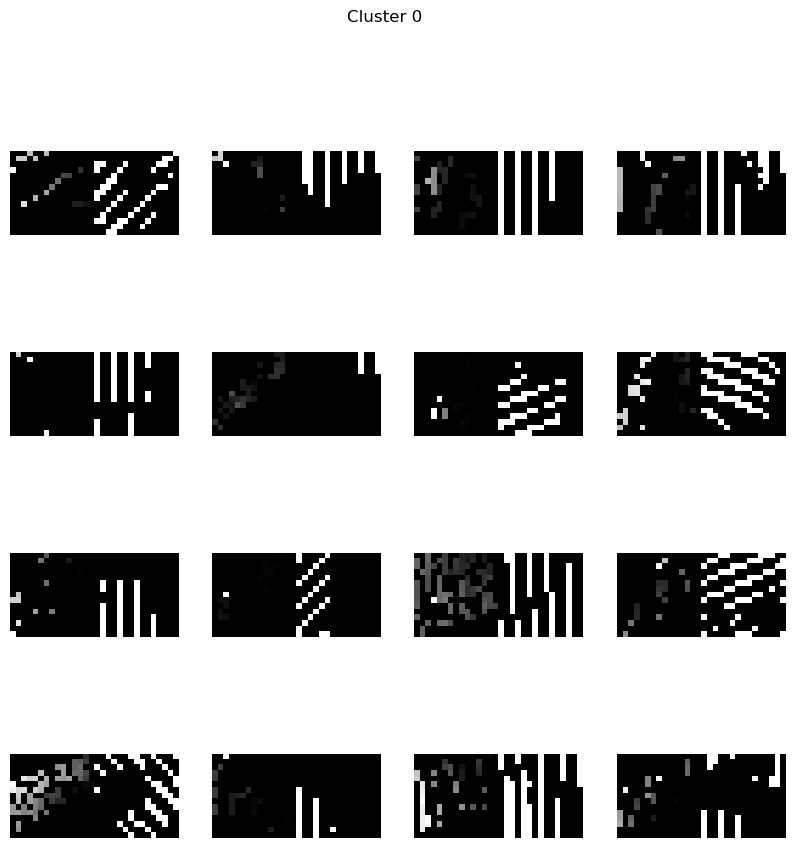

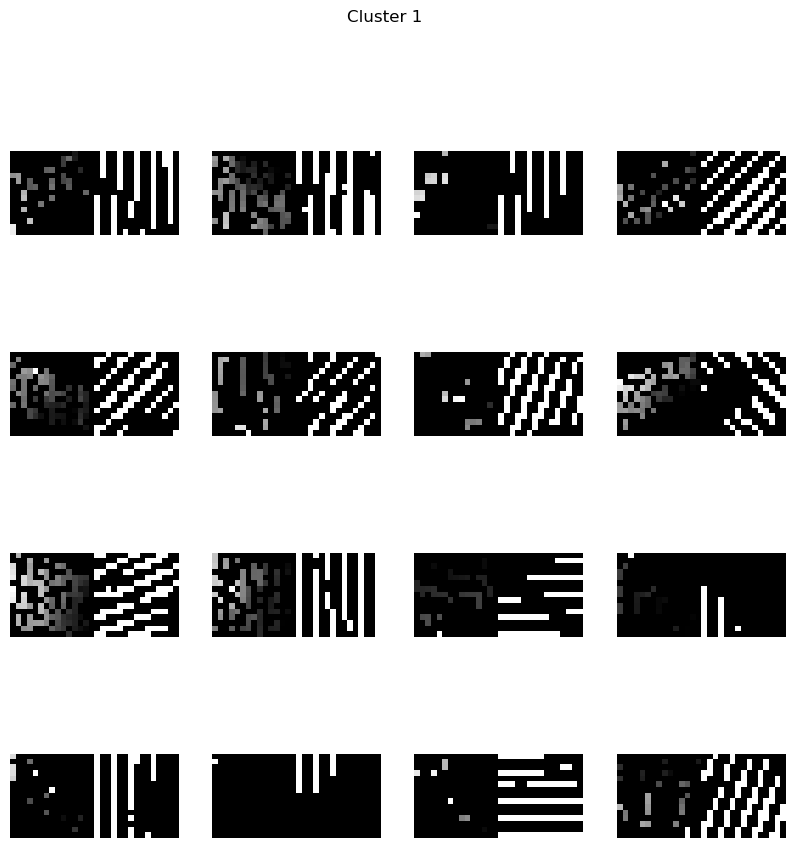

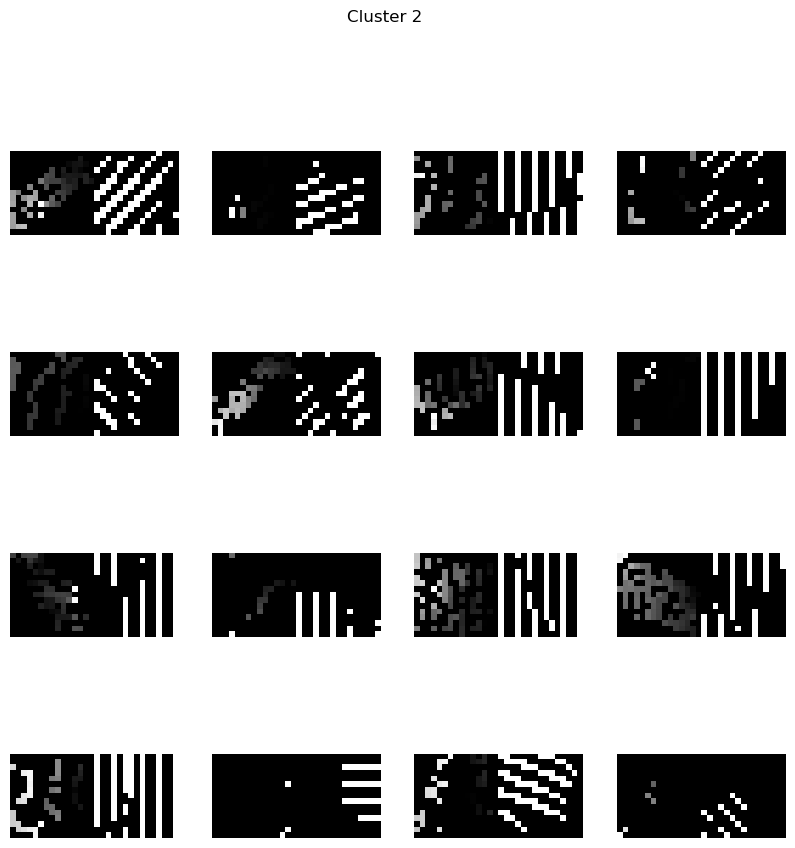

Clusters have been visualized by stripe pattern repetition.


In [50]:
sorted_clusters, sector_cluster_mapping,average_similarity = czm.visualize_clusters(images, image_sector_indices, n_clusters=3, base_output_folder='output_clusters') # 인스턴스 czm을 통해 메서드를 호출

In [16]:
print(sector_cluster_mapping)

{(0, 0, 1): 2, (0, 0, 2): 1, (0, 0, 30): 1, (0, 0, 31): 1, (0, 0, 32): 2, (0, 0, 33): 1, (0, 0, 35): 1, (0, 0, 37): 1, (0, 0, 38): 1, (0, 0, 52): 1, (0, 0, 64): 0, (0, 0, 68): 1, (0, 0, 70): 1, (0, 0, 71): 1, (0, 1, 1): 0, (0, 1, 3): 0, (0, 1, 14): 2, (0, 1, 32): 1, (0, 1, 33): 1, (0, 1, 34): 1, (0, 1, 35): 2, (0, 1, 37): 1, (0, 1, 71): 1, (0, 2, 17): 0, (0, 2, 33): 1, (0, 2, 34): 1, (0, 2, 35): 1, (0, 2, 37): 1, (0, 2, 38): 0, (0, 2, 71): 2, (0, 3, 32): 1, (0, 3, 33): 1, (0, 3, 34): 2, (0, 3, 35): 2, (0, 3, 37): 0, (0, 3, 38): 2, (0, 3, 61): 0, (0, 3, 71): 0, (1, 0, 22): 1, (1, 0, 23): 2, (1, 0, 27): 2, (1, 1, 22): 2, (1, 1, 28): 2, (1, 2, 22): 2, (1, 2, 23): 2, (1, 2, 26): 0, (1, 2, 27): 2, (1, 3, 22): 2, (1, 3, 23): 0, (2, 0, 22): 0, (2, 0, 23): 2, (2, 1, 22): 0}


In [19]:
mean_cluster_z_variances, cluster_residual_means = czm.calculate_cluster_z_variance(sectors, sector_cluster_mapping)

[(2, 0.017143947895468963), (1, 0.020144348598441622), (0, 0.051933449984996466)]
[(2, 0.0011475111735187022), (1, 0.0020327932502873865), (0, 0.023261160205678658)]


In [ ]:
def calculate_order_percentage(pcd_directory_path):
    matching_count = 0
    total_count = 0

    x1_values, y1_values, z1_values = [], [], []
    x2_values, y2_values, z2_values = [], [], []
    x3_values, y3_values, z3_values = [], [], []

    pcd_files = list(Path(pcd_directory_path).glob('*.pcd'))[:50]
    for pcd_file_path in pcd_files:
        czm = CZM(str(pcd_file_path))
        sectors, sector_indices = czm.segment_czm()
        images, image_sector_indices = czm.process_sectors(sectors)
        sorted_clusters, sector_cluster_mapping = czm.visualize_clusters(images, image_sector_indices, n_clusters=3, base_output_folder='output_clusters') # base_output_folder 추가
        mean_cluster_z_variances, cluster_residual_means= czm.calculate_cluster_z_variance(sectors, sector_cluster_mapping)

        # sorted_clusters와 mean_cluster_z_variances의 첫 번째 항목 추출
        sorted_clusters_order = [item[0] for item in sorted_clusters]
        sorted_clusters_order_2 = [item[1] for item in sorted_clusters]
        print(sorted_clusters_order)
        mean_cluster_order = [item[0] for item in mean_cluster_z_variances]
        mean_cluster_order_2 = [item[1] for item in mean_cluster_z_variances]
        print(mean_cluster_order)
        mean_residual_cluster_order = [item[0] for item in cluster_residual_means]
        mean_residual_cluster_order_2 = [item[1] for item in cluster_residual_means]

        x1_values.append(sorted_clusters_order_2[0])
        x2_values.append(mean_cluster_order_2[0])
        x3_values.append(mean_residual_cluster_order_2[0])
        y1_values.append(sorted_clusters_order_2[1])
        y2_values.append(mean_cluster_order_2[1])
        y3_values.append(mean_residual_cluster_order_2[1])
        z1_values.append(sorted_clusters_order_2[2])
        z2_values.append(mean_cluster_order_2[2])
        z3_values.append(mean_residual_cluster_order_2[2])



        if sorted_clusters_order == mean_cluster_order:
            matching_count += 1

        total_count += 1

    percentage = (matching_count / total_count) * 100

    correlation_x = np.corrcoef(x1_values, x2_values)[0, 1]
    print(f"Correlation between x1 and x2: {correlation_x}")

    correlation_y = np.corrcoef(y1_values, y2_values)[0, 1]
    print(f"Correlation between y1 and y2: {correlation_y}")

    correlation_z = np.corrcoef(z1_values, z2_values)[0, 1]
    print(f"Correlation between z1 and z2: {correlation_z}")

    plt.figure(figsize=(10, 3))

    plt.plot(x1_values, label='x1_values', color='red')
    plt.plot(x2_values, label='x2_values', color='blue')
    plt.title('Line plot of x1 and x2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.plot(y1_values, label='y1_values', color='green')
    plt.plot(y2_values, label='y2_values', color='purple')
    plt.title('Line plot of y1 and y2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 3))
    plt.plot(z1_values, label='z1_values', color='orange')
    plt.plot(z2_values, label='z2_values', color='brown')
    plt.title('Line plot of z1 and z2')
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.legend()
    plt.show()
    
    return x1_values, x2_values, x3_values, y1_values, y2_values, y3_values, z1_values, z2_values, z3_values, percentage

pcd_directory_path = "/media/rtlink/JetsonSSD-256/Download/Rellis_3D_os1_cloud_node_color_ply/Rellis-3D/00000/os1_cloud_node_color_ply/pcd_files/"
x1_values, x2_values, x3_values, y1_values, y2_values, y3_values, z1_values, z2_values, z3_values, percentage = calculate_order_percentage(pcd_directory_path)
print(f"Percentage of PCD files with matching orders: {percentage}%")


In [293]:
print(np.mean(x1_values))
print(np.mean(x2_values))
print(np.mean(x3_values))
print(np.mean(y1_values))
print(np.mean(y2_values))
print(np.mean(y3_values))
print(np.mean(z1_values))
print(np.mean(z2_values))
print(np.mean(z3_values))

7.143220969027198
0.0015003963427160467
0.017317398781177475
5.097217806352955
0.0041932714824510255
0.02454317296044347
2.701179805745513
0.010677277444106736
0.041753936627063046
